In [62]:
from ipywidgets import *
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6
style = {'description_width': 'initial'}
layout = Layout(width = '400px')
models = [None] * 4 

## Реалізація МНКО

In [477]:
def RMNK(X, y, verbose=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if m > 1:
        w, H_inv = RMNK(X[:,:-1], y, verbose=verbose) # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]
        h = X[:,:-1].T @ X[:,-1] # shape = [m-1, 1]
        eta = X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T * alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T, (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        
    if verbose:
        print('=============================================')
        print('\tStep {}'.format(m))
        print('=============================================')
        print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
        print('eta_{}:\t\t{}'.format(m, eta))
        print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
        print('beta_{}:\t\t{}'.format(m, beta))
        print('gamma_{}:\t{}'.format(m, gamma))
        print('nu_{}:\t\t{}'.format(m, nu))
        print('=============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
    return w, H_next_inv

## 1. Модель Фергюльста

### Рівняння моделі
### $N'=μN(k-N) \enspace | \enspace N_0$ 

### Різницеве рівняння
### $\Delta t = 1$
### $N'(t)≈ N(t+1)-N(t) \enspace (forward\:difference)$
### $ \Rightarrow \left \{ \begin{array}{ll}N(t+1)-N(t)=μN(t)[k-N(t)] \\ N(0) = N_0\end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}N(t+1)=(μk+1)N(t)-μN^2(t) \\ N(0) = N_0\end{array} \right. $
### $y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i, \enspace \enspace θ_1 = μk+1; \enspace θ_2 = -μ; \enspace Eξ = 0_n; \enspace cov(ξ) = σ^2I_n$
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = μk+1; \enspace θ_2 = -μ\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $

In [476]:
# Lab 1
def model1(k, μ, N0):
    
    def model1_eq(N, t):
        return μ * N * (k - N)
    
    t = np.linspace(0, 30, num=200)

    # solve ODE
    N = odeint(model1_eq, N0, t)

    # plot results
    plt.plot(t,N)
    plt.xlabel('t')
    plt.ylabel('N(t)')
    plt.show()

description1 = Label(value="$N'=μN(k-N)$")
k_val = FloatText(value= 15, description = 'Ємність середовища (гранична чисельність): $k = $', step=0.1, style = style, layout = layout)
μ_val = FloatText(value = 0.05, description = 'Швидкість росту популяції: $μ = $', step=0.1, style = style, layout = layout)
N0_val = FloatText(value=0.5, description = 'Початковий розмір популяції: $N_0 = $', step=0.1, style = style, layout = layout)
models[0] = VBox([description1, interactive(model1, k=k_val, μ=μ_val, N0=N0_val, continuous_update=True)])

# display(models[0])

Initial parameters:	μ = 0.0001
			k = 100
			N0 = 10

Noise generationn: C = 3
Sample length: n = 50
Time starting from 0 to 500 with discretization frequency 10



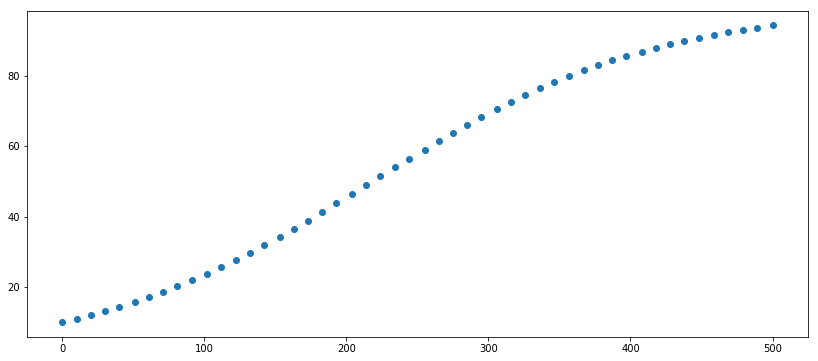

Intermediate parameters values: θ_1 = 1.01	θ_2 = -0.0001
Regression model: y = (1.01) * x1 + (-0.0001) * x2


,i,t,N(t),N^2(t),N(t+1)
0,1,0,10.000000,100.000000,10.090
1,2,10,10.956582,120.046684,11.054
2,3,20,11.992475,143.819461,12.098
3,4,30,13.111886,171.921546,13.226
4,5,40,14.318785,205.027597,14.441
5,6,51,15.616808,243.884680,15.749
6,7,61,17.009139,289.310822,17.150
7,8,71,18.498393,342.190549,18.649
8,9,81,20.086481,403.466709,20.247
9,10,91,21.774481,474.128027,21.945


In [501]:
# Lab 2
def Verhulst_model_equation(N, t, μ, k):
    return μ * N * (k - N)


class VerhulstModelConfig(): 
    k = 100
    μ = 0.0001
    N0 = 10
    t_start = 0
    t_end = 500
    num_samples = 50
    num_samples_grid = [10, 50, 100]
    C = 3
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.N = odeint(Verhulst_model_equation, self.N0, self.t, (self.μ, self.k))
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tμ = {}\n\t\t\tk = {}\n\t\t\tN0 = {}\n'.format(self.μ, self.k, self.N0))
        print('Noise generationn: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} with discretization frequency {}\n'.format(self.t_start,
                                                                                     self.t_end,
                                                                                     self.h))
        
    def init_to_inter_params(self):
        return np.array([self.μ * self.k + 1, -self.μ])

    def inter_to_init_params(self, w1, w2):
        μ = - w2
        k = (1 - w1) / w2
        return μ, k



config = VerhulstModelConfig()
config.show()

def get_sample_df(config):
    df = pd.DataFrame()
    df['i'] = range(1, config.num_samples+1)
    df['t'] = list(map(int, config.t))
    df['N(t)'] = config.N.flatten()
    df['N^2(t)'] = np.square(config.N.flatten())
    df['N(t+1)'] = np.array(df[['N(t)','N^2(t)']]) @ config.theta
    df['N(t+1)'] = np.round(df['N(t+1)'], config.C)
    return df

df = get_sample_df(config)
plt.scatter(df['t'], df['N(t+1)'])
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*theta))
df

In [486]:
X = np.array(df[['N(t)', 'N^2(t)']])
y = np.array(df['N(t+1)'])
print('Recurrent Least Squares Method')
theta_pred = RMNK(X, y, verbose=True)[0][:,0]
μ_pred, k_pred = config.inter_to_init_params(*theta_pred)
print('=============================================')
print('\nINTERMEDIATE PARAMETERS')
print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*theta_pred))
print('\nINITIAL PARAMETERS')
print('True values:\tμ = {}\tk = {}'.format(config.μ, config.k))
print('Estimates:\tμ* = {}\tk* = {}'.format(μ_pred, k_pred))

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		192021.11695382808
alpha_1:	[0]
beta_1:		192021.11695382808
gamma_1:	192454.57239914758
nu_1:		[1.00225733]
> θ_1: [1.00225733]
> H_1_inv:
[[5.20776056e-06]]
	Step 2
h_2:		[14865979.31260227]
eta_2:		1210738873.994198
alpha_2:	[77.41846078]
beta_2:		[59837637.56477976]
gamma_2:	14893552.79759949
nu_2:		[-0.0001]
> θ_2: [ 1.00999944e+00 -1.00003420e-04]
> H_2_inv:
[[ 1.05372445e-04 -1.29380878e-06]
 [-1.29380878e-06  1.67118897e-08]]

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.01	θ_2 = -0.0001
Estimates:	θ_1* = 1.0099994430189054	θ_2* = -0.00010000341994466655

INITIAL PARAMETERS
True values:	μ = 0.0001	k = 100
Estimates:	μ* = 0.00010000341994466655	k* = 99.9910105518219


In [496]:
intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'θ_1*', 'θ_2*'])
initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples', 'μ*', 'k*'])
for C in config.C_grid:
    for num_samples in config.num_samples_grid: 
        config.recompile(C, num_samples)
        df = get_sample_df(config)
        X = np.array(df[['N(t)', 'N^2(t)']])
        y = np.array(df['N(t+1)'])
        intermediate_estimates_df
        theta_pred = RMNK(X, y, verbose=False)[0][:,0]
        μ_pred, k_pred = config.inter_to_init_params(*theta_pred)
        intermediate_estimates_df = \
        intermediate_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                          'θ_1*': theta_pred[0], 'θ_2*': theta_pred[1]},
                                         ignore_index=True)
        initial_estimates_df = \
        initial_estimates_df.append({'C': config.C, 'num_samples': config.num_samples,
                                     'μ*': μ_pred, 'k*': k_pred},
                                     ignore_index=True)
        if config.verbose_grid_search:
            print('=============================================================')
            print('C: {}\t num_samples: {}'.format(config.C, config.num_samples))
            print('\nINTERMEDIATE PARAMETERS')
            print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
            print('\nINITIAL PARAMETERS')
            print('Estimates:\tμ* = {: 12.8}\tk* = {: 12.8}'.format(μ_pred, k_pred))
            
print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('True init.  params values:\tμ = {}\tk = {}'.format(config.μ, float(config.k)))
pd.concat([intermediate_estimates_df, initial_estimates_df[['μ*', 'k*']]], axis=1)

True inter. params values:	θ_1 = 1.01	θ_2 = -0.0001
True init.  params values:	μ = 0.0001	k = 100.0


,C,num_samples,θ_1*,θ_2*,μ*,k*
0,0.0,10.0,0.998957,0.000044,-0.000044,23.826999
1,0.0,50.0,1.010265,-0.000106,0.000106,96.768521
2,0.0,100.0,1.009688,-0.000097,0.000097,100.083587
3,2.0,10.0,1.009857,-0.000098,0.000098,100.559471
4,2.0,50.0,1.009994,-0.000100,0.000100,100.105598
5,2.0,100.0,1.009956,-0.000099,0.000099,100.113571
6,5.0,10.0,1.010000,-0.000100,0.000100,100.000233
7,5.0,50.0,1.010000,-0.000100,0.000100,100.000141
8,5.0,100.0,1.010000,-0.000100,0.000100,100.000091


## 3. Рівняння вимушених коливань

### Модель рівняння
### $x''+2δ x'+ω_0^2 x=0$

### Різницеве рівняння
### $\Delta t = 1$
### $x'(t)≈ x(t+1)-x(t)\enspace (forward \: difference)$
### $x'(t)≈ \frac{x(t+1)-x(t-1)}{2}\enspace (central \: difference)$
### $x''(t)≈ x(t+1)-2x(t)+x(t-1)$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+2δ[x(t+1)-x(t)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2+2δ-ω_0^2}{1+2δ}x(t+1)-\frac{1}{1+2δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2+2δ-ω_0^2}{1+2δ}; \enspace θ_2 = -\frac{1}{1+2δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $

In [498]:
# Lab 1
def model3(δ, ω0, ω, f0, x0, x00):
    #x_0' = x_1 = x'
    #x_1' = x'' = f0 * np.cos(ω * t) - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    def model3_eq(x,t):
        return [x[1], f0 * np.cos(ω * t) - 2 * δ * x[1] - (ω0 ** 2) * x[0]]

    t = np.linspace(0,300, num=1000)

    # solve ODE
    x = odeint(model3_eq, np.array([x0, x00]), t)

    # plot results
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].plot(t, x[:,0])
    ax[0].set_xlabel('t')
    ax[0].set_ylabel('x(t)')
    ax[1].plot(x[:,0], x[:,1])
    ax[1].set_xlabel('x(t)')
    ax[1].set_ylabel("x'(t)")
    plt.show()

description3 = Label(value="$x''+2δ x'+ω_0^2 x=f_0 cos(ωt)$")
δ_val = FloatText( description = 'Коефіцієнт згасання: $δ = $', step=0.1, style = style, layout = layout)
ω0_val = FloatText(description = 'Власна частота: $ω_0 = $', step=0.1, style = style, layout = layout)
ω_val = FloatText(description = 'Частота зовнішньої сили: $ω = $', step=0.1, style = style, layout = layout)
f0_val = FloatText(description = 'Амплітуда зовнішньої сили: $f_0 = $', step=0.1, style = style, layout = layout)
x0_val = FloatText( description = 'Початкове положення: $x_0 = $', step=0.1, style = style, layout = layout)
x00_val = FloatText(description = "Початкова швидкіть: $x_0' = $", step=0.1, style = style, layout = layout)
models[2] = VBox([description3, interactive(model3, δ=δ_val, ω0=ω0_val, ω=ω_val, f0=f0_val, x0=x0_val, x00=x00_val, continuous_update=True)])

# display(models[2])

In [ ]:
# Lab 2
def Oscillation_model_equation(x, t, δ, ω0):
    #x_0' = x_1 = x'
    #x_1' = x'' = - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    return [x[1],  - 2 * δ * x[1] - (ω0 ** 2) * x[0]]
        

class OscillationModelConfig(): 
    δ = 0.001
    ω0 = 10
    x0 = 0
    x00 = 0
    t_start = 0
    t_end = 500
    num_samples = 50
    num_samples_grid = [10, 50, 100]
    C = 3
    C_grid = [0, 2, 5]
    verbose_grid_search = False

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.x = odeint(Oscillation_model_equation, np.array([self.x0, self.x00]), self.t, (self.δ, self.ω0))
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tδ = {}\n\t\t\tω0 = {}\
              \n\t\t\tx0 = {}\n\t\t\tx00 = {}\n'.format(self.δ, self.ω0, self.x0, self.x00))
        print('Noise generationn: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} with discretization frequency {}\n'.format(self.t_start,
                                                                                     self.t_end,
                                                                                     self.h))
        
    def init_to_inter_params(self):
        return np.array([self.μ * self.k + 1, -self.μ])

    def inter_to_init_params(self, w1, w2):
        μ = - w2
        k = (1 - w1) / w2
        return μ, k



config = VerhulstModelConfig()
config.show()

def get_sample_df(config):
    df = pd.DataFrame()
    df['i'] = range(1, config.num_samples+1)
    df['t'] = list(map(int, config.t))
    df['N(t)'] = config.N.flatten()
    df['N^2(t)'] = np.square(config.N.flatten())
    df['N(t+1)'] = np.array(df[['N(t)','N^2(t)']]) @ config.theta
    df['N(t+1)'] = np.round(df['N(t+1)'], config.C)
    return df

df = get_sample_df(config)
plt.scatter(df['t'], df['N(t+1)'])
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*theta))
df